In [1]:
!where python

c:\Users\HK-Laptop-V639\Documents\GitHub\696\env696\Scripts\python.exe
C:\Users\HK-Laptop-V639\AppData\Local\Programs\Python\Python312\python.exe
C:\Users\HK-Laptop-V639\AppData\Local\Microsoft\WindowsApps\python.exe


In [2]:
# run this code to make sure you install all the required libraries
# be sure you are in virtual environment before install, otherwise it will overwrite your local environment

#!pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

In [4]:
# fix random state
RANDOM_SEED = 123

import torch
import random
import os
os.environ["OMP_NUM_THREADS"] = "1"
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
# import necessary assets
import joblib

train_dl = joblib.load('assets/train_deep_learning_with_theme.joblib')
test_dl = joblib.load('assets/test_deep_learning_with_theme.joblib')

In [6]:
train_dl.sample(5)

,title,type,score,scored_by,status,episodes/chapters,source,members,favorites,sfw,genres,themes,demographics,creators,production_source,synopsis,title_english,title_japanese,is_anime,start_year,end_year,start_season,end_season,topic_BERTopic_score,theme_assigned
14757,Argate Online,manga,6.41,1315,currently_publishing,NaN,NaN,4493,5,True,"[Action, Adventure, Fantasy]",[],[],"[Rei, Tsumugu Touno]",[AlphaPolis Web Manga],"Izu Takashi was just playing the online game ""...",Argate Online,アルゲートオンライン,False,2017.0,NaN,Summer,NaN,0.333815,Fantasy Adventure / Isekai (alternate world)
9542,Demi-chan wa Kataritai,manga,7.75,6130,finished,78.0,NaN,24171,268,True,"[Comedy, Fantasy]",[School],[Seinen],[Petosu],[Young Magazine (Monthly)],"Succubus, Dullahan and Vampire. They are known...",Interviews with Monster Girls,亜人〈デミ〉ちゃんは語りたい,False,2014.0,2022.0,Summer,Autumn,0.000706,High School Life and Romance
12400,Tadareta Koi ni wa Itashimasen!,manga,6.99,1229,finished,6.0,NaN,2352,5,False,"[Boys Love, Comedy, Erotica]",[],[],[Shouko Rakuta],[LiQulle],"On his first day living alone in Tokyo, Kyouhe...",I'm Looking for Serious Love!,ただれた恋にはいたしません!,False,2018.0,2019.0,Summer,Winter,0.017270,High School Life and Romance
11375,Mayonaka Love Alliance,manga,7.23,1411,finished,6.0,NaN,2986,11,False,"[Boys Love, Erotica]",[],[],[Atami Michinoku],[Qpa],1-2. Otoshiana ni Hamerarete\r\n3-4. Pinup Boy...,The Love Alliance in Midnight,真夜中ラブアライアンス,False,2016.0,2016.0,Winter,Autumn,0.002446,Romance with sensitive content
7637,Nandaku Mou,music,5.28,123,finished_airing,1.0,music,262,0,True,[],[Music],[],[Onionskin],[Hipland Music Corporation],"A music video for Kidori Kidori's song ""Nandak...",Nandaku-mou,なんだかもう,True,2015.0,2015.0,Spring,Spring,0.005932,"Music, Bands, and Performances"


In [7]:
train_dl.shape

(19453, 25)

In [8]:
train_dl_score = train_dl.dropna(subset='score').copy()
train_dl_score.shape

(13484, 25)

In [9]:
test_dl_score = test_dl.dropna(subset='score').copy()

In [10]:
import matplotlib.pyplot as plt

def outliers_evaluation(target, threshold = 3):
    df = train_dl_score

    mean = np.mean(df[target])
    std = np.std(df[target])

    outliers = np.abs(df[target] - mean) > threshold * std
    num_outliers = np.sum(outliers)

    print(f"Number of outliers: {num_outliers} ")
    print(f"proportion: {num_outliers / len(df[target])}")

    # Boxplot to visually identify outliers
    plt.boxplot(df[target])
    plt.title("Boxplot of Target Variable")
    plt.show()

Number of outliers: 92 
proportion: 0.006822901216256304


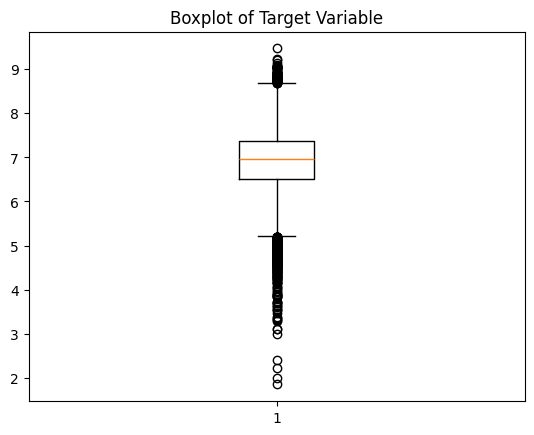

In [11]:
outliers_evaluation('score')

# Score prediction

In [12]:
single_cat_columns = ['type', 'status', 'source', 'start_season', 'end_season', 'theme_assigned']
multi_cat_columns = ['genres', 'demographics', 'creators', 'production_source', 'themes']
numeric_columns = ['scored_by', 'episodes/chapters', 'members', 'favorites', 'start_year', 'end_year', 'topic_BERTopic_score']
boolean_columns = ['sfw', 'is_anime']

## Pre-processing

1. Handle Missing Values for Single Categorical Columns: Fill with 'Missing'.
2. Label Encode Single Categorical and Multi-Categorical Columns.
3. Pad Multi-Categorical Columns with 0 after label encoding.
4. Use KNN Imputation for numerical columns using all categorical and boolean columns as features for imputation.
5. Standardize the imputed numerical columns.
6. Pass through PyTorch model with embeddings for categorical features and dense layers for numerical features.

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

# Step 1: Handle Missing Values in Single Categorical Columns
for col in single_cat_columns:
    train_dl_score[col] = train_dl_score[col].fillna('Missing')

# Step 2: Label Encode Single Categorical Columns
single_cat_label_encoders = {}
for col in single_cat_columns:
    all_categories = train_dl_score[col].unique().tolist()

    # Fit the LabelEncoder with the extended list of categories
    le = LabelEncoder().fit(all_categories)
    single_cat_label_encoders[col] = le
    train_dl_score[col + '_encoded'] = le.transform(train_dl_score[col])

# Step 3: Label Encode and Pad Multi-Categorical Columns
multi_cat_label_encoders = {}
max_seq_len_per_column = {}
for col in multi_cat_columns:
    all_categories = set(item for sublist in train_dl_score[col] for item in sublist)  # Set of unique categories

    le = LabelEncoder().fit(list(all_categories))

    # Label encode each element in the list
    train_dl_score[col + '_encoded'] = train_dl_score[col].apply(lambda x: (le.transform(x) + 1).tolist()) # Shift encoded values by 1 to avoid using 0
    multi_cat_label_encoders[col] = le

    # Compute the max sequence length for the current column
    max_seq_len_per_column[col] = max(train_dl_score[col + '_encoded'].apply(len))
    
    # Pad sequences with 0 (padding index)
    PADDING_VALUE = 0
    padded_sequences = pad_sequence(
        [torch.tensor(row, dtype=torch.int64) for row in train_dl_score[col + '_encoded']],
        batch_first=True, padding_value=PADDING_VALUE
    )
    
    # Convert padded sequences into a list of tensors (1D arrays)
    train_dl_score[col + '_encoded_padded'] = list(padded_sequences.numpy())

In [14]:
train_dl_score.sample(3)

,title,type,score,scored_by,status,episodes/chapters,source,members,favorites,sfw,genres,themes,demographics,creators,production_source,synopsis,title_english,title_japanese,is_anime,start_year,end_year,start_season,end_season,topic_BERTopic_score,theme_assigned,type_encoded,status_encoded,source_encoded,start_season_encoded,end_season_encoded,theme_assigned_encoded,genres_encoded,genres_encoded_padded,demographics_encoded,demographics_encoded_padded,creators_encoded,creators_encoded_padded,production_source_encoded,production_source_encoded_padded,themes_encoded,themes_encoded_padded
14455,Summer Solstice Point,manhwa,7.12,235,finished,NaN,Missing,543,4,False,"[Drama, Erotica, Romance]",[],[],[Yuju],[],"""I've never kissed anyone before... so help me...",Summer Solstice Point,하지점,False,2019.0,2020.0,Autumn,Summer,0.717827,"Adult Life, Work, and Relationships",5,3,1,0,3,1,"[7, 9, 16]","[7, 9, 16, 0, 0, 0, 0, 0, 0, 0]",[],"[0, 0]",[6585],"[6585, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],"[0, 0, 0, 0, 0, 0]"
12514,"Kouchuugun Shikan, Boukensha ni Naru",manga,7.03,934,currently_publishing,NaN,Missing,3242,22,True,"[Action, Adventure, Fantasy, Sci-Fi]",[],[],"[Tomomasa Takuma, Atsuhiko Ito]",[Dengeki Comic Regulus],The spaceship which Imperial Galactic Navy Off...,Captain Corinth: The Galactic Navy Officer Bec...,航宙軍士官、冒険者になる,False,2018.0,NaN,Autumn,Missing,0.696713,"Sci-Fi, Space, and Mecha Battles",3,1,1,0,1,8,"[1, 2, 10, 17]","[1, 2, 10, 17, 0, 0, 0, 0, 0, 0]",[],"[0, 0]","[5939, 375]","[5939, 375, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",[502],"[502, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",[],"[0, 0, 0, 0, 0, 0]"
13502,Dungeon ni Deai wo Motomeru no wa Machigatteir...,manga,6.96,563,finished,35.0,Missing,1973,5,True,"[Action, Comedy, Fantasy]",[],[],[Masaya Takamura],[Gangan Online],4-koma spin-off of the Dungeon ni Deai wo Moto...,Is It Wrong to Try to Pick Up Girls in a Dunge...,ダンジョンに出会いを求めるのは間違っているだろうか4コマ,False,2014.0,2017.0,Summer,Spring,0.018872,Romance with sensitive content,3,3,1,3,2,6,"[1, 6, 10]","[1, 6, 10, 0, 0, 0, 0, 0, 0, 0]",[],"[0, 0]",[3297],"[3297, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[635],"[635, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",[],"[0, 0, 0, 0, 0, 0]"


In [15]:
# Step 4: KNN Imputation for Numerical Columns
# Use all categorical and boolean columns (label-encoded) for imputation
imputation_features = [col + '_encoded' for col in single_cat_columns] + boolean_columns
knn_imputer = KNNImputer(n_neighbors=5)

# Combine categorical, boolean, and numeric columns for imputation
combined_data = np.hstack([train_dl_score[imputation_features].values, train_dl_score[numeric_columns + ['score']].values])
imputed_data = knn_imputer.fit_transform(combined_data)

# Update the dataframe with imputed numerical values
train_dl_score[numeric_columns + ['score']] = imputed_data[:, -len(numeric_columns + ['score']):]

# Step 5: Standardize the Imputed Numerical Columns
scaler = StandardScaler()
train_dl_score[numeric_columns] = scaler.fit_transform(train_dl_score[numeric_columns])

scaler_score = StandardScaler() # Separate score scaler for inverse transform score prediction later
train_dl_score[['score']] = scaler_score.fit_transform(train_dl_score[['score']])

In [16]:
train_dl_score.isnull().sum()

title                               0
type                                0
score                               0
scored_by                           0
status                              0
episodes/chapters                   0
source                              0
members                             0
favorites                           0
sfw                                 0
genres                              0
themes                              0
demographics                        0
creators                            0
production_source                   0
synopsis                            0
title_english                       0
title_japanese                      0
is_anime                            0
start_year                          0
end_year                            0
start_season                        0
end_season                          0
topic_BERTopic_score                0
theme_assigned                      0
type_encoded                        0
status_encod

### Apply same transformation on test set

In [17]:
# Step 1: Handle Missing Values in Single Categorical Columns
for col in single_cat_columns:
    test_dl_score[col] = test_dl_score[col].fillna('Missing')

# Step 2: Label Encode Single Categorical Columns
for col in single_cat_columns:
    le = single_cat_label_encoders[col]  # Use the pre-fitted label encoder

    # Add "Unknown" to label encoder classes for handling unseen categories
    train_classes = le.classes_
    le.classes_ = np.append(train_classes, "Unknown")

    # Apply safe transformation for single categorical columns
    def safe_transform_single(value):
        if value in le.classes_:
            return le.transform([value])[0]
        else:
            return le.transform(["Unknown"])[0]

    test_dl_score[col + '_encoded'] = test_dl_score[col].apply(safe_transform_single)

# Step 3: Label Encode and Pad Multi-Categorical Columns for Test Set
for col in multi_cat_columns:
    le = multi_cat_label_encoders[col]  # Use the pre-fitted label encoder
    
    # Add "Unknown" to label encoder classes for handling unseen categories
    train_classes = le.classes_
    le.classes_ = np.append(train_classes, "Unknown")

    # Apply safe transformation for each element in the multi-categorical list
    def safe_transform_multi(values):
        transformed_values = []
        for item in values:
            if item in le.classes_:
                transformed_values.append((le.transform([item]) + 1)[0])
            else:
                transformed_values.append((le.transform(["Unknown"]) + 1)[0])
        return transformed_values

    test_dl_score[col + '_encoded'] = test_dl_score[col].apply(safe_transform_multi)
    
    # Pad sequences with 0 (padding index)
    max_seq_len = max_seq_len_per_column[col]

    padded_sequences = pad_sequence(
        [torch.tensor(row, dtype=torch.int64) for row in test_dl_score[col + '_encoded']],
        batch_first=True, padding_value=PADDING_VALUE
    )

    # Ensure test set sequences are padded to the same length as the training set
    padded_sequences = torch.nn.functional.pad(
        padded_sequences, (0, max_seq_len - padded_sequences.size(1)), value=PADDING_VALUE
    )
    
    # Convert padded sequences into a list of tensors (1D arrays)
    test_dl_score[col + '_encoded_padded'] = list(padded_sequences.numpy())

# Step 4: KNN Imputation for Numerical Columns
combined_data = np.hstack([test_dl_score[imputation_features].values, test_dl_score[numeric_columns + ['score']].values])
imputed_data = knn_imputer.transform(combined_data)
test_dl_score[numeric_columns + ['score']] = imputed_data[:, -len(numeric_columns + ['score']):]

# Step 5: Standardize the Imputed Numerical Columns
test_dl_score[numeric_columns] = scaler.transform(test_dl_score[numeric_columns])
test_dl_score[['score']] = scaler_score.transform(test_dl_score[['score']])

## Prepare PyTorch Dataset

In [18]:
from torch.utils.data import Dataset

class AnimeMangaDataset(Dataset):
    def __init__(self, single_cat_inputs, multi_cat_inputs, numeric_inputs, boolean_inputs, target_scores):
        self.single_cat_inputs = single_cat_inputs
        self.multi_cat_inputs = multi_cat_inputs
        self.numeric_inputs = numeric_inputs
        self.boolean_inputs = boolean_inputs
        self.target_scores = target_scores

    def __len__(self):
        return len(self.target_scores)

    def __getitem__(self, idx):
        # For each sample, return the inputs and the corresponding target (score)
        single_cat_input = self.single_cat_inputs[idx]
        multi_cat_input = [multi_cat[idx] for multi_cat in self.multi_cat_inputs]  # Extract each multi-cat feature
        numeric_input = self.numeric_inputs[idx]
        boolean_input = self.boolean_inputs[idx]

        # Combine input into single tensor
        all_input = torch.cat([single_cat_input, *multi_cat_input, numeric_input, boolean_input])

        target = self.target_scores[idx]
        
        return all_input, target
    
# Convert the target score into a tensor
target_scores = torch.tensor(train_dl_score['score'].values, dtype=torch.float32)

# Convert ALL single categorical columns into a tensor
single_cat_inputs = torch.tensor(train_dl_score[[col + '_encoded' for col in single_cat_columns]].values)

# Convert EACH multiple categorical column into a tensor
multi_cat_inputs = [
    torch.tensor(np.stack(train_dl_score[col + '_encoded_padded'].values), dtype=torch.int64)
    for col in multi_cat_columns
]

# Convert ALL numerical columns into a tensor
numeric_inputs = torch.tensor(train_dl_score[numeric_columns].values, dtype=torch.float32)

# Convert ALL boolean columns into a tensor
boolean_inputs = torch.tensor(train_dl_score[boolean_columns].values)

# Create an instance of the custom dataset
dataset = AnimeMangaDataset(single_cat_inputs, multi_cat_inputs, numeric_inputs, boolean_inputs, target_scores)

In [19]:
# Number of columns for each type of inputs
single_cat_n_columns = single_cat_inputs.shape[1]
multi_cat_n_columns = [tensor.shape[1] for tensor in multi_cat_inputs]
numeric_n_columns = numeric_inputs.shape[1]
boolean_n_columns = boolean_inputs.shape[1]

### Test set

In [20]:
# Convert the target score into a tensor
target_scores_test = torch.tensor(test_dl_score['score'].values, dtype=torch.float32)

# Convert ALL single categorical columns into a tensor
single_cat_inputs_test = torch.tensor(test_dl_score[[col + '_encoded' for col in single_cat_columns]].values)

# Convert EACH multiple categorical column into a tensor
multi_cat_inputs_test = [
    torch.tensor(np.stack(test_dl_score[col + '_encoded_padded'].values), dtype=torch.int64)
    for col in multi_cat_columns
]

# Convert ALL numerical columns into a tensor
numeric_inputs_test = torch.tensor(test_dl_score[numeric_columns].values, dtype=torch.float32)

# Convert ALL boolean columns into a tensor
boolean_inputs_test = torch.tensor(test_dl_score[boolean_columns].values)

# Create an instance of the custom dataset for the test set
dataset_test = AnimeMangaDataset(single_cat_inputs_test, multi_cat_inputs_test, numeric_inputs_test, boolean_inputs_test, target_scores_test)

## Prepare Model

In [21]:
class AnimeMangaModel(nn.Module):
    def __init__(self, single_cat_dims, multi_cat_dims, embedding_dim, num_numeric, num_boolean, hidden_sizes, dropout_rate):
        super(AnimeMangaModel, self).__init__()

        # Embedding layers for single categorical columns
        self.single_cat_embeddings = nn.ModuleList([
            nn.Embedding(cat_dim, embedding_dim) for cat_dim in single_cat_dims
        ])

        # Embedding layers for multi-categorical columns with padding
        self.multi_cat_embeddings = nn.ModuleList([
            nn.Embedding(cat_dim, embedding_dim, padding_idx=PADDING_VALUE) for cat_dim in multi_cat_dims
        ])

        # Layer normalization for each single categorical embedding
        self.single_cat_layer_norms = nn.ModuleList([
            nn.LayerNorm(embedding_dim) for _ in single_cat_dims
        ])

        # Layer normalization for each multi-categorical embedding
        self.multi_cat_layer_norms = nn.ModuleList([
            nn.LayerNorm(embedding_dim) for _ in multi_cat_dims
        ])

        # Dense layer for numeric and boolean inputs
        self.numeric_dense = nn.Linear(num_numeric, embedding_dim)
        self.boolean_dense = nn.Linear(num_boolean, embedding_dim)

        # Fully connected layers setup
        self.fc_layers = nn.ModuleList()

        # Batch normalization setup
        self.batch_norm_layers = nn.ModuleList()

        # Drop out
        self.dropout = nn.Dropout(dropout_rate)

        input_size = embedding_dim * (len(single_cat_dims) + len(multi_cat_dims) + 2)

        for hidden_size in hidden_sizes:
            self.fc_layers.append(nn.Linear(input_size, hidden_size)) # Fully connected layers
            self.batch_norm_layers.append(nn.BatchNorm1d(hidden_size)) # Batch normalization
            input_size = hidden_size
        self.output = nn.Linear(input_size, 1)  # Output for regression

    def forward(self, all_inputs):
        # Extract single categorical columns
        single_cat_inputs = all_inputs[:, :single_cat_n_columns]

        # Extract multi-categorical columns
        i = 0
        multi_cat_inputs = []
        for n_col in multi_cat_n_columns:
            multi_cat_inputs.append(all_inputs[:, single_cat_n_columns + i:single_cat_n_columns + i + n_col])
            i += n_col

        # Extract numerical columns
        numeric_inputs = all_inputs[:, single_cat_n_columns + sum(multi_cat_n_columns):single_cat_n_columns + sum(multi_cat_n_columns) + numeric_n_columns]

        # Extract Boolean columns
        boolean_inputs = all_inputs[:, single_cat_n_columns + sum(multi_cat_n_columns) + numeric_n_columns:single_cat_n_columns + sum(multi_cat_n_columns) + numeric_n_columns + boolean_n_columns]

        # Process single categorical columns through embeddings and normalize
        single_cat_embeds = [
            self.single_cat_layer_norms[i](embed(single_cat_inputs[:, i].type(torch.long))) 
            for i, embed in enumerate(self.single_cat_embeddings)
        ]

        # Process multi-categorical columns through embeddings with max pooling the most representative category for each feature and then normalize
        multi_cat_embeds = [
            self.multi_cat_layer_norms[i](torch.max(embed(multi_cat_inputs[i].type(torch.long)), dim=1)[0])
            for i, embed in enumerate(self.multi_cat_embeddings)
        ]

        # Process numeric and boolean features through dense layers
        numeric_out = torch.relu(self.numeric_dense(numeric_inputs))
        boolean_out = torch.relu(self.boolean_dense(boolean_inputs.float()))

        # Concatenate all features together
        combined = torch.cat(single_cat_embeds + multi_cat_embeds + [numeric_out, boolean_out], dim=1)

        # Pass through fully connected layers
        x = combined
        for fc_layer, batch_norm_layer in zip(self.fc_layers, self.batch_norm_layers):
            x = torch.relu(fc_layer(x))
            x = batch_norm_layer(x)
            x = self.dropout(x)
        output = self.output(x)  # Regression output
        
        return output
    
# Dimensions for embedding layers
# Add 1 dimension for the additional "Unknown" category in test set
single_cat_dims = [train_dl_score[col + '_encoded'].nunique() + 1 for col in single_cat_columns]
multi_cat_dims = [train_dl_score[col + '_encoded_padded'].apply(lambda x: max(x)).max() + 2 for col in multi_cat_columns]

## Training Loop (with cross validation)

In [25]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from sklearn.model_selection import KFold
import optuna


K_FOLDS = 5
NUM_EPOCHS = 10
PATIENCE = 3
N_TRIALS = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up Optuna's logging system
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    # Hyperparameter suggestions by Optuna
    embedding_dim = trial.suggest_int('embedding_dim', 4, 16)
    num_layers = trial.suggest_int('num_layers', 2, 5)
    hidden_sizes = [trial.suggest_int(f'hidden_size_{i}', 16, 128) for i in range(num_layers)]
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # K-Fold Cross Validation
    kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    targets = train_dl_score['score'].values
    fold_results = []

    # To store the trail loss
    trial_training_loss = []
    trial_validation_loss = []

    trial_best_val_loss = float('inf')  # Initialize global best validation loss
    trial_best_model_state = None  # Initialize global best model state


    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(targets)))):
        # Create Subsets and DataLoader for the current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(RANDOM_SEED))
        val_loader = DataLoader(val_subset, batch_size=batch_size * 2, shuffle=False)

        # Initialize model for each fold
        model = AnimeMangaModel(
            single_cat_dims=single_cat_dims,
            multi_cat_dims=multi_cat_dims,
            embedding_dim=embedding_dim,
            num_numeric=len(numeric_columns),
            num_boolean=len(boolean_columns),
            hidden_sizes=hidden_sizes,
            dropout_rate=dropout_rate
        ).to(device)

        # Define optimizer and loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()

        # Initialization for each fold
        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_state = None
        fold_train_loss = []
        fold_val_loss = []

        # Training loop with early stopping
        for epoch in range(NUM_EPOCHS):
            model.train()
            train_loss = 0

            for batch in train_loader:
                input_batch, target_batch = batch
                input_batch = input_batch.to(device)
                target_batch = target_batch.to(device)

                optimizer.zero_grad() # Zero the parameter gradients
                output = model(input_batch) # Forward pass
                loss = criterion(output.squeeze(), target_batch) # Compute loss
                loss.backward() # Backward pass
                optimizer.step() # Optimization
                train_loss += loss.item() # Accumulate training loss

            train_loss /= len(train_loader) # Average train loss for this fold
            fold_train_loss.append(train_loss)

            # Validation loop
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    input_batch, target_batch = batch
                    input_batch = input_batch.to(device)
                    target_batch = target_batch.to(device)

                    output = model(input_batch) # Forward pass
                    loss = criterion(output.squeeze(), target_batch) # Compute loss
                    val_loss += loss.item() # Accumulate validation loss

            val_loss /= len(val_loader) # Average validation loss for this fold
            fold_val_loss.append(val_loss)

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                
                if val_loss < trial_best_val_loss:
                    trial_best_val_loss = val_loss
                    trial_best_model_state = model.state_dict()  # Save trail best model state
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= PATIENCE:
                break

        fold_results.append(best_val_loss)
        trial_training_loss.append(fold_train_loss)
        trial_validation_loss.append(fold_val_loss)

    trial.set_user_attr('fold_results', fold_results)

    # Average validation loss across all folds
    average_val_loss = np.mean(fold_results)

    # Save the best model state
    trial.set_user_attr("best_model_state", trial_best_model_state)

    # Save metrics for later plotting
    trial.set_user_attr('training_loss', trial_training_loss)
    trial.set_user_attr('validation_loss', trial_validation_loss)

    return average_val_loss

# Create a study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS)

# Reconstruct the best model
best_trial = study.best_trial
best_model_state = best_trial.user_attrs["best_model_state"]
embedding_dim = best_trial.params['embedding_dim']
num_layers = best_trial.params['num_layers']
hidden_sizes = [best_trial.params[f'hidden_size_{i}'] for i in range(num_layers)]
dropout_rate = best_trial.params['dropout_rate']

best_model = AnimeMangaModel(
    single_cat_dims=single_cat_dims,
    multi_cat_dims=multi_cat_dims,
    embedding_dim=embedding_dim,
    num_numeric=len(numeric_columns),
    num_boolean=len(boolean_columns),
    hidden_sizes=hidden_sizes,
    dropout_rate=dropout_rate
).to(device)

best_model.load_state_dict(best_model_state)
# Save trained model
torch.save(best_model, 'assets/PyTorch_trained_model.pth')

# Compute standard deviations
best_trial_fold_results = best_trial.user_attrs['fold_results']
mse_std = np.std(best_trial_fold_results)
rmse_values = np.sqrt(best_trial_fold_results)
rmse_std = np.std(rmse_values)

# Print the best result
print('Best trial:')
print(f'  MSE Mean: {best_trial.value}')
print(f'  MSE Sd: {mse_std}')
print(f'  RMSE Mean: {np.sqrt(best_trial.value)}')
print(f'  RMSE Sd: {rmse_std}')
print('  Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

[I 2024-10-25 10:35:35,421] A new study created in memory with name: no-name-f005ba52-d7b3-48df-8b90-389c72ca32e2
[I 2024-10-25 10:41:13,704] Trial 0 finished with value: 0.4734998672148761 and parameters: {'embedding_dim': 11, 'num_layers': 4, 'hidden_size_0': 96, 'hidden_size_1': 39, 'hidden_size_2': 18, 'hidden_size_3': 114, 'learning_rate': 0.0044919779856605075, 'batch_size': 16, 'dropout_rate': 0.2834148246466935}. Best is trial 0 with value: 0.4734998672148761.
[I 2024-10-25 10:48:19,449] Trial 1 finished with value: 0.5480604070074419 and parameters: {'embedding_dim': 9, 'num_layers': 3, 'hidden_size_0': 114, 'hidden_size_1': 58, 'hidden_size_2': 41, 'learning_rate': 0.0002238234916809235, 'batch_size': 16, 'dropout_rate': 0.4243348954055952}. Best is trial 0 with value: 0.4734998672148761.
[I 2024-10-25 10:51:57,527] Trial 2 finished with value: 0.491779299808103 and parameters: {'embedding_dim': 15, 'num_layers': 5, 'hidden_size_0': 105, 'hidden_size_1': 75, 'hidden_size_2': 

Best trial:
  MSE Mean: 0.4734998672148761
  MSE Sd: 0.055895156772801276
  RMSE Mean: 0.6881132662686253
  RMSE Sd: 0.04004620658225487
  Params: 
    embedding_dim: 11
    num_layers: 4
    hidden_size_0: 96
    hidden_size_1: 39
    hidden_size_2: 18
    hidden_size_3: 114
    learning_rate: 0.0044919779856605075
    batch_size: 16
    dropout_rate: 0.2834148246466935


## Apply model in test set

In [26]:
best_model = torch.load('assets/PyTorch_trained_model.pth')

C:\Users\HK-Laptop-V639\AppData\Local\Temp\ipykernel_11076\1585137324.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('assets/PyTorch_trained_mod

In [27]:
test_loader = DataLoader(dataset_test, batch_size=best_trial.params['batch_size'] * 2, shuffle=False)

best_model.eval()

criterion = nn.MSELoss()

# Initialize variables to accumulate loss
test_loss = 0
predictions = []
true_targets = []

# Disable gradient calculations for evaluation
with torch.no_grad():
    for batch in test_loader:
        input_batch, target_batch = batch
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)

        output = best_model(input_batch) # Forward pass
        loss = criterion(output.squeeze(), target_batch) # Compute loss
        test_loss += loss.item() # Accumulate test loss

        # Store predictions and true targets for later evaluation
        predictions.extend(output.squeeze().cpu().numpy())
        true_targets.extend(target_batch.cpu().numpy())

test_dl_score['score_prediction'] = predictions

# Average test loss
test_loss /= len(test_loader)
rmse = np.sqrt(test_loss)

print(f'Test MSE: {test_loss}')
print(f'Test RMSE: {rmse}')

Test MSE: 0.4018472028228472
Test RMSE: 0.6339141920030243


In [28]:
# Inverse transform standardize columns for better readability
test_dl_score[numeric_columns] = scaler.inverse_transform(test_dl_score[numeric_columns])
test_dl_score[['score']] = scaler_score.inverse_transform(test_dl_score[['score']])
test_dl_score[['score_prediction']] = scaler_score.inverse_transform(test_dl_score[['score_prediction']])

## Evaluation

### Feature analysis

In [29]:
feature_names = single_cat_columns + [col
    for i, col in enumerate(multi_cat_columns)
    for _ in range(multi_cat_n_columns[i])
] + numeric_columns + boolean_columns

  0%|          | 0/200 [00:00<?, ?it/s]

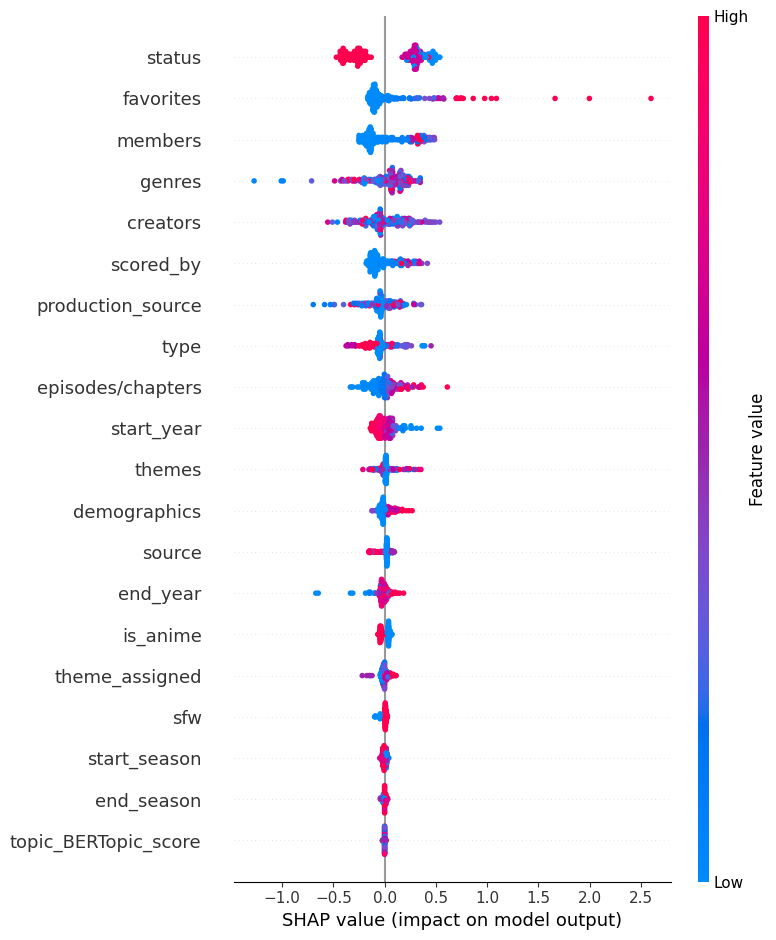

In [55]:
import shap

best_model.eval()

def model_wrapper(input_data):
    with torch.no_grad():
        input_tensor = torch.tensor(input_data).float()
        output_tensor = best_model(input_tensor)
        return output_tensor.numpy()

sample_data = [input_batch for input_batch, _ in test_loader]
sample_data = torch.cat(sample_data, dim=0)

# Use a subset of data as background data
background_data = sample_data[np.random.choice(sample_data.shape[0], 100, replace=False)].numpy()

# Create a KernelExplainer for the model
explainer = shap.KernelExplainer(model_wrapper, background_data)

# Get SHAP values for a batch of samples
feature_data_batch = sample_data[np.random.choice(sample_data.shape[0], 200, replace=False)].numpy()  # Extract feature data for multiple instances
shap_values = explainer.shap_values(feature_data_batch)

# Convert SHAP values to float64 and squeeze to remove the singleton dimension
shap_values = np.squeeze(np.array(shap_values, dtype=np.float64))

# Ensure feature data is float64
feature_data_batch = feature_data_batch.astype(np.float64)

# Aggregate multi-categorical columns
shap_value_df = pd.DataFrame(shap_values, columns=feature_names)
shap_value_df = shap_value_df.T.groupby(shap_value_df.columns).sum().T

feature_data_df = pd.DataFrame(feature_data_batch, columns=feature_names)
feature_data_df = feature_data_df.T.groupby(feature_data_df.columns).sum().T

# Visualize SHAP summary plot
shap.initjs()
shap.summary_plot(shap_value_df.values, feature_data_df.values, feature_names=list(shap_value_df.columns))


In [71]:
{index: label for index, label in enumerate(single_cat_label_encoders['status'].classes_)}

{0: 'currently_airing',
 1: 'currently_publishing',
 2: 'discontinued',
 3: 'finished',
 4: 'finished_airing',
 5: 'on_hiatus',
 6: 'Unknown'}

### Residual analysis

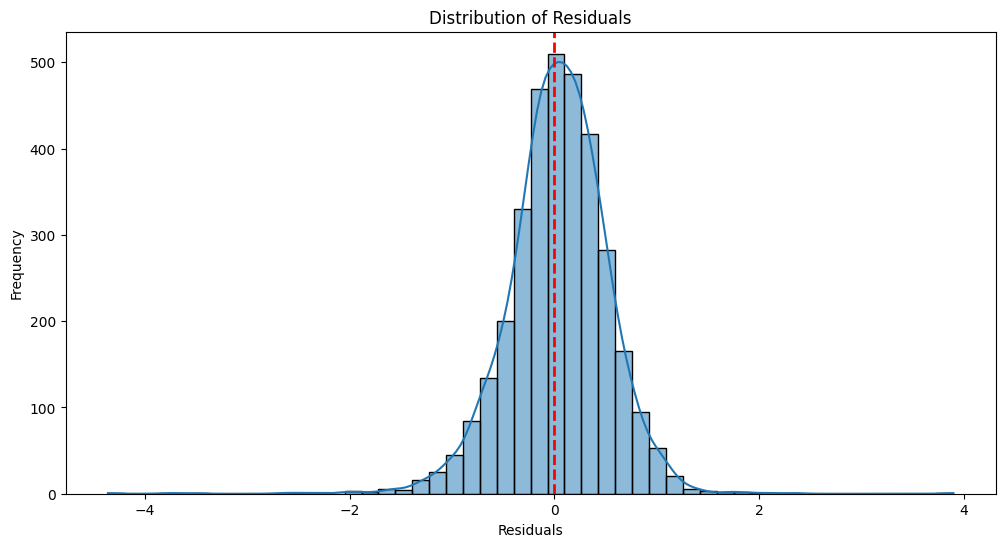

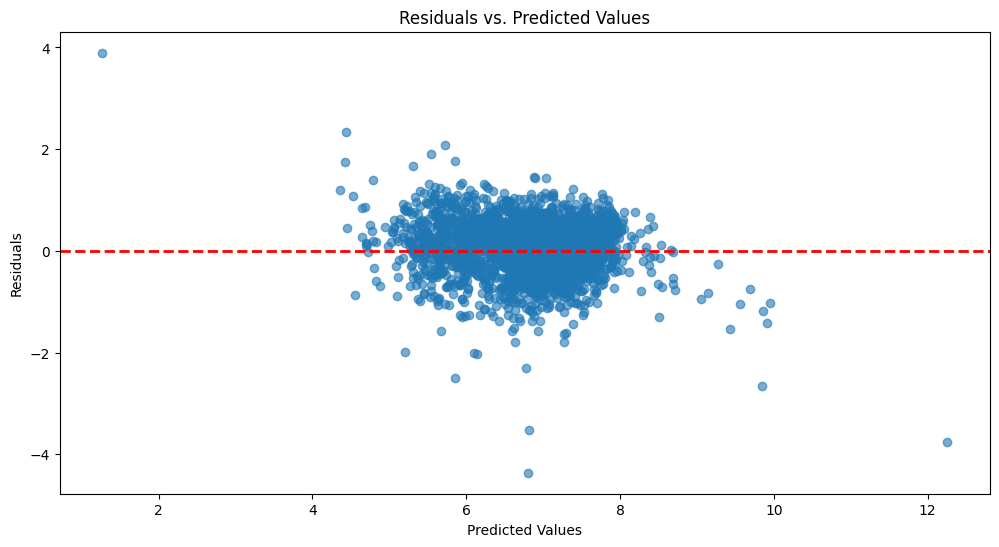

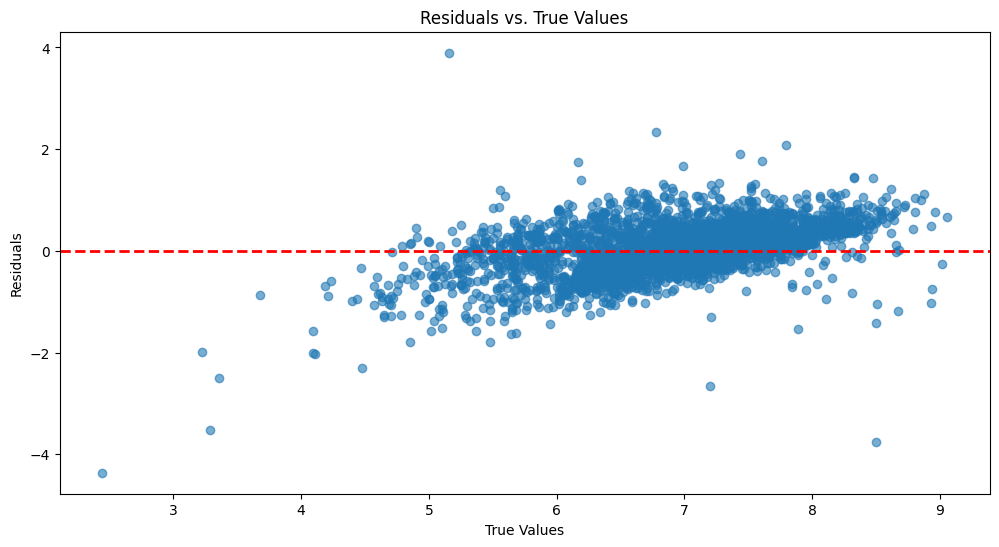

In [74]:
import seaborn as sns

test_dl_score['residual'] = test_dl_score['score'] - test_dl_score['score_prediction']

# Residual Distribution
plt.figure(figsize=(12, 6))
sns.histplot(test_dl_score['residual'], bins=50, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.axvline(0, color='r', linestyle='--', lw=2)
plt.show()

# Residuals vs. Predictions
plt.figure(figsize=(12, 6))
plt.scatter(test_dl_score['score_prediction'], test_dl_score['residual'], alpha=0.6)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

# Plot Residuals vs. True Targets
plt.figure(figsize=(12, 6))
plt.scatter(test_dl_score['score'], test_dl_score['residual'], alpha=0.6)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. True Values')
plt.show()

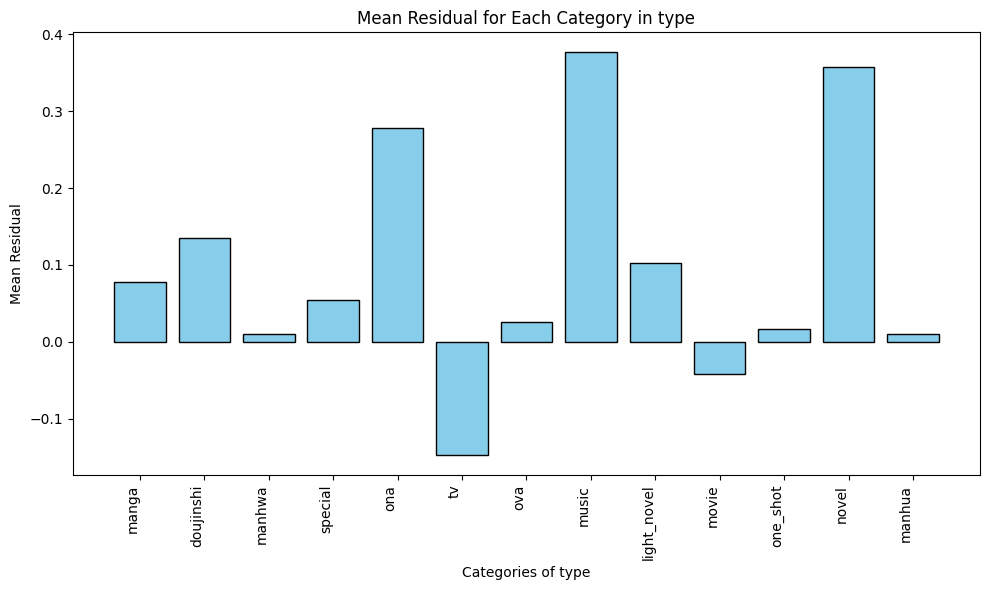

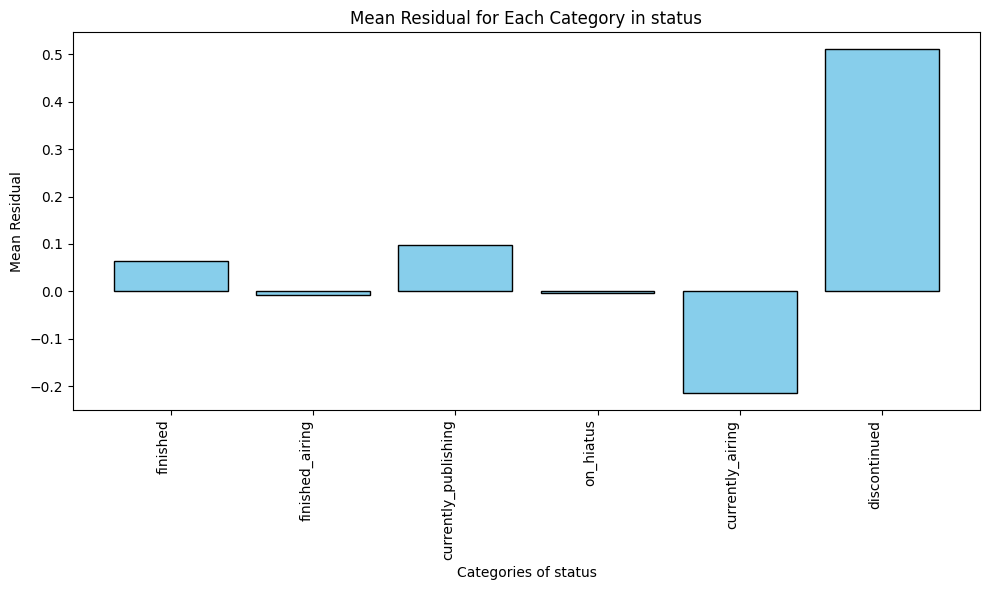

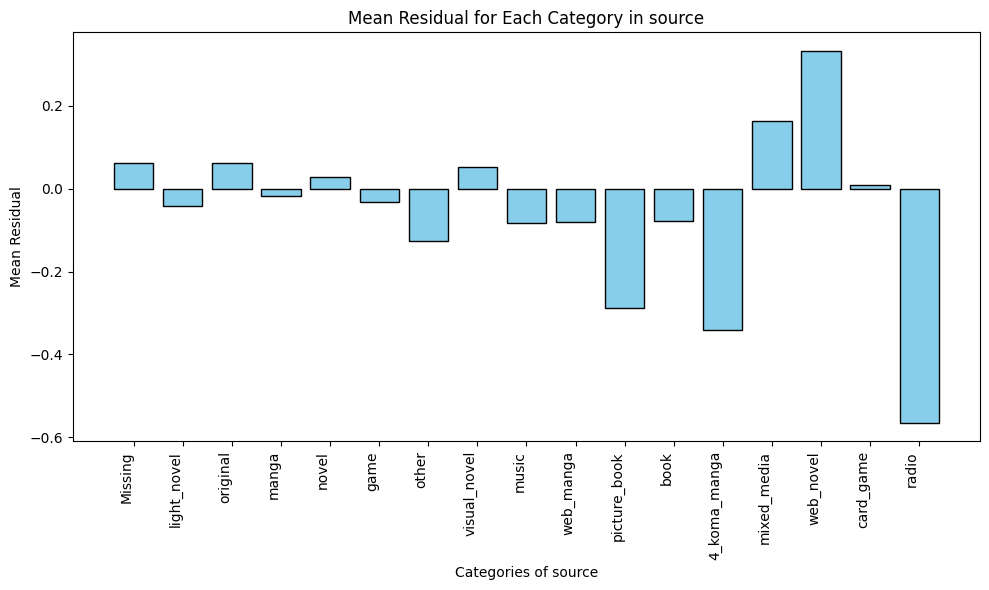

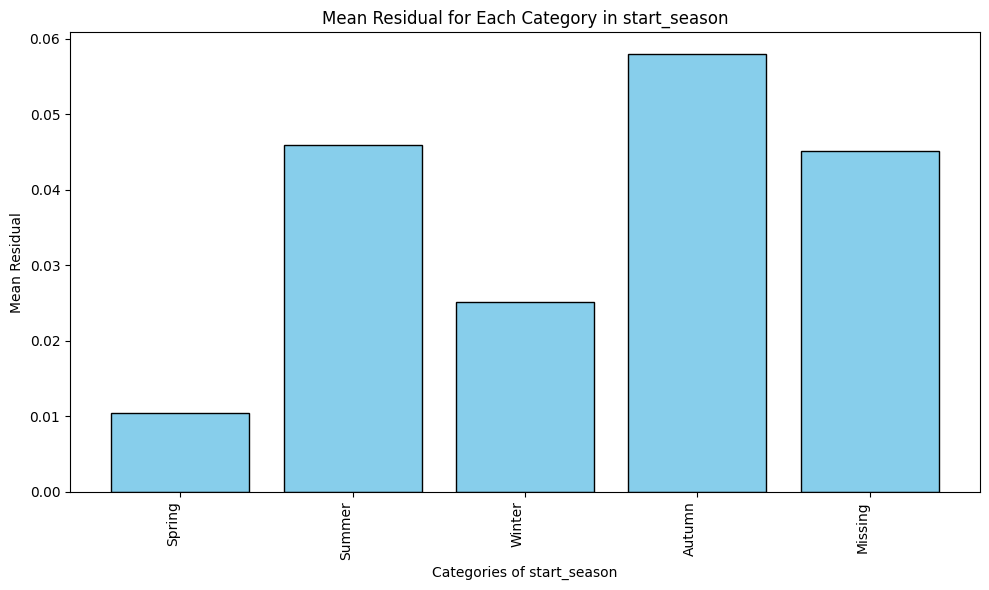

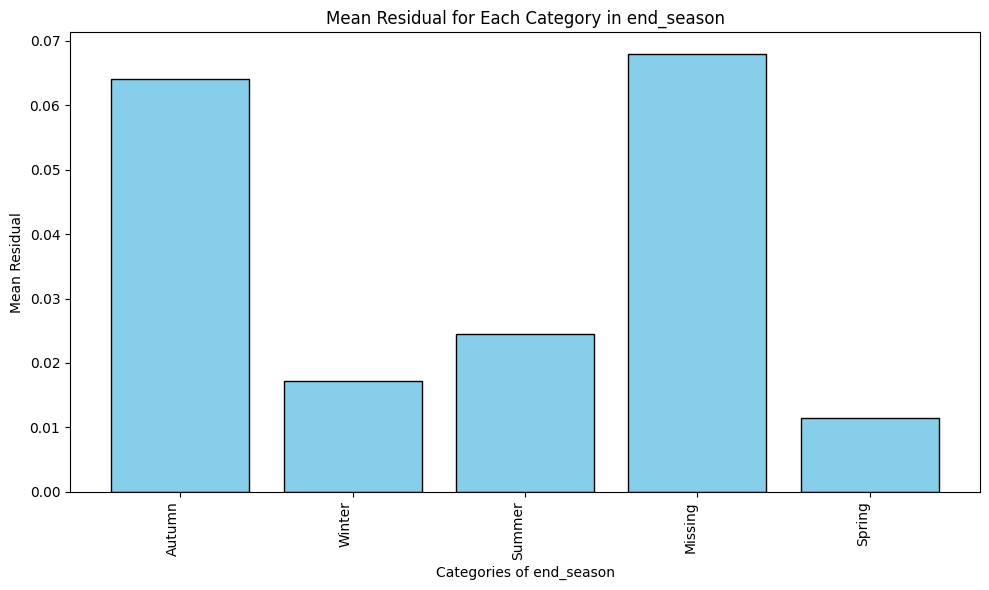

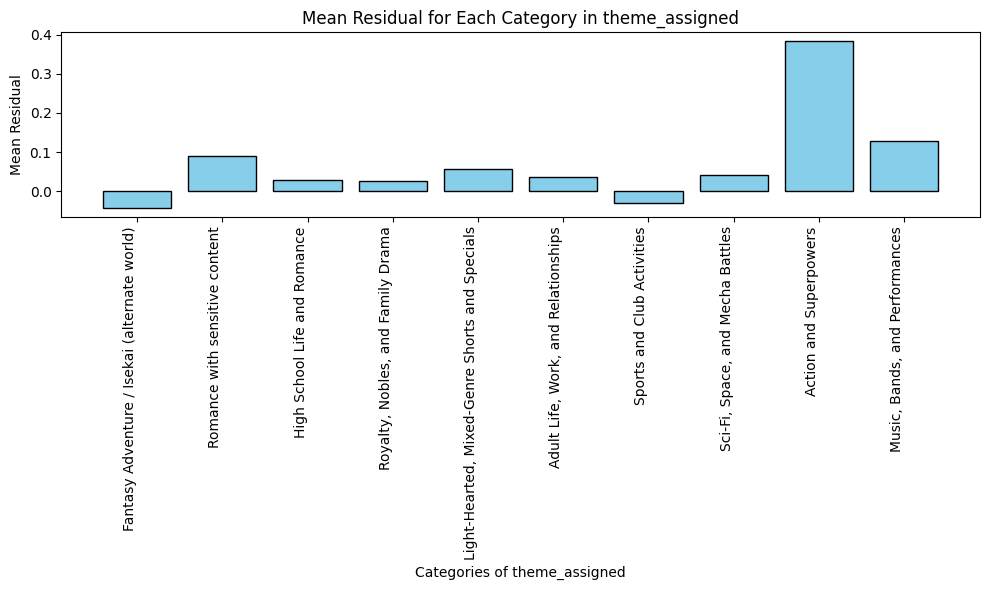

In [75]:
# Loop through categorical columns and plot mean residuals for each category
for col in single_cat_columns:
    category_values = test_dl_score[col].unique()
    mean_residuals = []

    for value in category_values:
        segment = test_dl_score[test_dl_score[col] == value]
        mean_residual = segment['residual'].mean()
        mean_residuals.append(mean_residual)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(category_values, mean_residuals, color='skyblue', edgecolor='black')
    plt.xlabel(f'Categories of {col}')
    plt.ylabel('Mean Residual')
    plt.title(f'Mean Residual for Each Category in {col}')
    plt.xticks(rotation=90, ha='right')
    plt.tight_layout()
    plt.show()


### Learning Curve Analysis

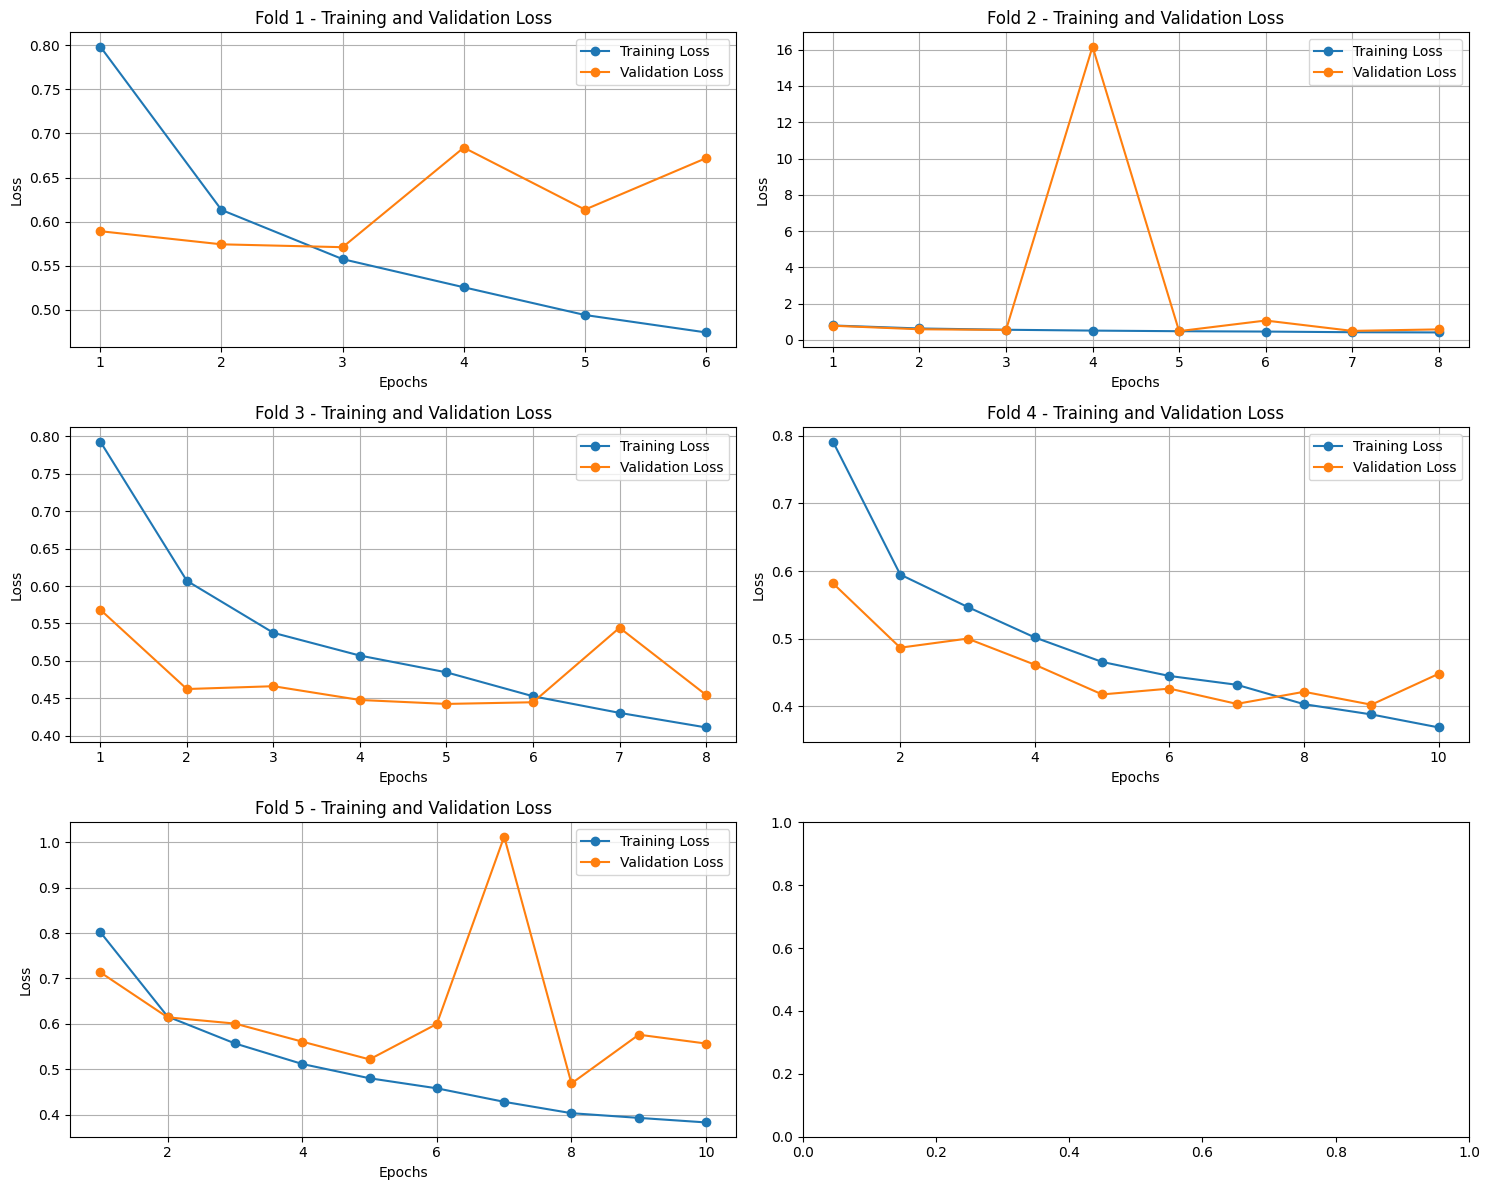

In [76]:
import matplotlib.pyplot as plt

best_training_loss = best_trial.user_attrs['training_loss']
best_validation_loss = best_trial.user_attrs['validation_loss']

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# Plot training and validation loss for each fold
for fold_idx, (train_loss, val_loss) in enumerate(zip(best_training_loss, best_validation_loss)):
    epochs = range(1, len(train_loss) + 1)
    axes[fold_idx].plot(epochs, train_loss, label='Training Loss', marker='o')
    axes[fold_idx].plot(epochs, val_loss, label='Validation Loss', marker='o')
    axes[fold_idx].set_xlabel('Epochs')
    axes[fold_idx].set_ylabel('Loss')
    axes[fold_idx].set_title(f'Fold {fold_idx + 1} - Training and Validation Loss')
    axes[fold_idx].legend()
    axes[fold_idx].grid()

plt.tight_layout()
plt.show()

In [77]:
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice
)

# Optimization History
plot_optimization_history(study).show()

### Hyperparameter Sensitivity Analysis

In [78]:
# Hyperparameter Importances
plot_param_importances(study).show()

In [79]:
# Parallel Coordinate
plot_parallel_coordinate(study).show()

In [80]:
# Slice Plot
plot_slice(study).show()

In [81]:
# store library version
# run every time before you commit
!pip freeze > requirements.txt